In [1]:
include("src\\ImportanceSampling.jl")
using Distributions
using ImportanceSampling
using Seaborn

## normal

In [2]:
function gen_w_normal(μ0::Vector{<:Real}, μ::Vector{<:Real}, Σ::Matrix{<:Real})
    invΣ = inv(Σ)
    dη = invΣ*(μ0-μ)
    C = exp(1/2*( dot(μ, invΣ*μ) - dot(μ0, invΣ*μ0) ))
    return (x::AbstractVector{<:Real}) -> C*exp(dot(x, dη))
end

function f!(r, x) 
    r[1] = x[1]
    r[2] = x[1]^2
    return r
end

f! (generic function with 1 method)

In [3]:
nmeans = 17
m0s = linspace(-4, 4, nmeans)
q = Normal()
ws = [gen_w_normal([m0], zeros(1), eye(1)) for m0 in m0s]
;

In [4]:
ntrials = 50
niters = 10_000
iss = Matrix(ntrials, nmeans)

for i in 1:nmeans
    for tr in 1:ntrials
        iss[tr, i] = ImportanceSampler(f!, 2, q, w=ws[i])
        update!(iss[tr, i]; niters=niters, batchsize=500)
    end
    print(i, " ")
end

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 

In [5]:
ms = first.(mean.(iss))
vs = first.(var.(iss))
nes = ne.(iss)
neσs = neσ.(iss)

est_v = vec(var(ms, 1))
ms_avg = vec(mean(ms, 1))
vs_avg = vec(mean(vs, 1))
nes_avg = vec(mean(nes, 1))
neσs_avg = vec(mean(neσs, 1))
;

In [6]:
m = zeros(1)
Σ = eye(1)
Λ = inv(1)
m0s_pred = linspace(first(m0s), last(m0s), 100)
nes_pred = niters * [exp(dot(m0, Λ*m0) - 1/2*dot(m, Λ*m)-1/2*dot(2*m0-m, Λ*(2*m0-m))) for m0 in m0s_pred];

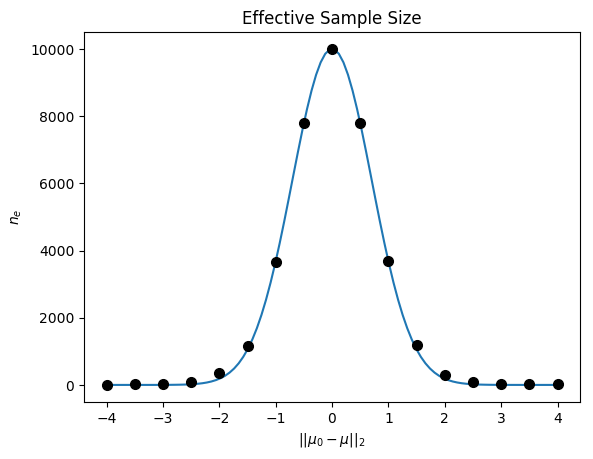

In [7]:
plot(m0s_pred, nes_pred) 
plot(m0s, nes_avg, "ko", ms=7)
title("Effective Sample Size")
xlabel(L"||\mu_0 - \mu ||_2")
ylabel(L"n_e")
;

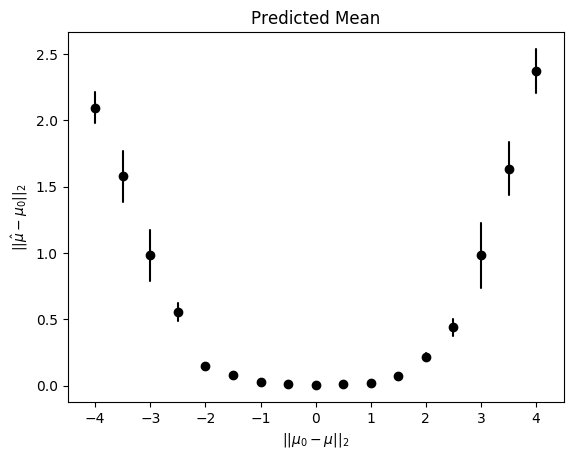

C:\Anaconda3\envs\conda_jl\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


In [8]:
tsplot(abs.(ms.-m0s'), m0s, err_style="ci_bars", interpolate=false, color="k")
title("Predicted Mean")
xlabel(L"||\mu_0 - \mu ||_2")
ylabel(L"||\hat \mu - \mu_0||_2")
;

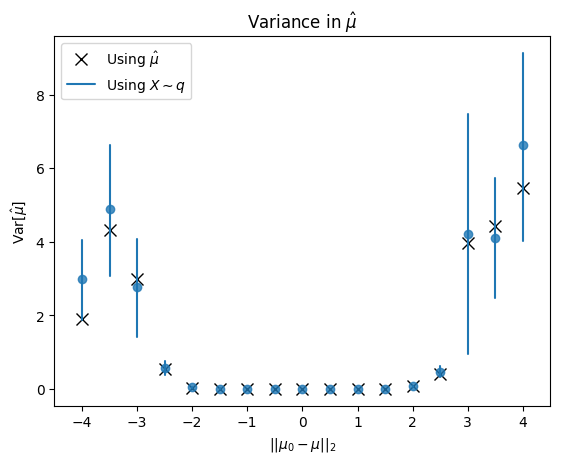

PyObject <matplotlib.legend.Legend object at 0x0000000039952208>

In [9]:
plot(m0s, est_v, "kx", ms="9")
tsplot(vs, m0s, err_style="ci_bars", interpolate=false, alpha=0.8)
title("Variance in " * L"\hat \mu")
xlabel(L"||\mu_0 - \mu ||_2")
ylabel(L"\mathrm{Var}[\hat \mu]")
legend(["Using " * L"\hat \mu", "Using " * L"X \sim q"])
;